In [2]:
import pandas as pd
import numpy as np


## 3D Mechanism
The 3D-Laplace mechanism uses three variates:
1. Gamma distribution with formula $D_\epsilon, R(r) = \frac{1}{2}\epsilon^3r^2 exp^{-\epsilon r}$
2. $D{\epsilon},\Theta(\theta) = \frac{1}{\pi}$
3. $D{\epsilon},\Psi(\psi) = \frac{1}{2\pi}$

Both $\theta$ and $\psi$ are generated based on a unit sphere (sphere [1,1]).
Ergo, 2 and 3 are a vector $U = (\theta, \psi)$ and are scaled according to 1. So, when we have a random point $x_0 \in R^3$, the noise is added using $x_0 + Ur$
This is in line with the spherical coordinate system:

 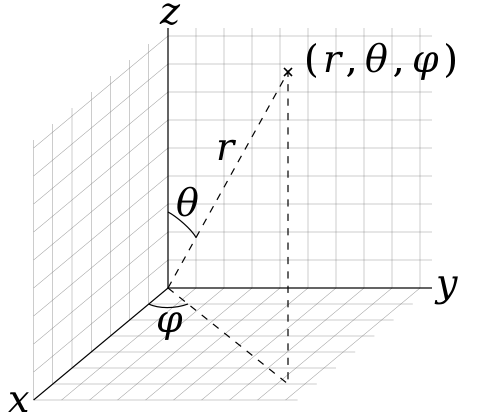
 


Steps to convert to nD-Laplace would then be:
- Instead of a unit sphere, we need to generate a unit hypersphere
- Modify the gaussian scaling

One of the difficulties for this is, we can't visualize it.


## nD-Laplace research
A hypersphere is conventionally defined as: $x1^2+x^2+x3^3+...+xd^2 < R^2$.
We are be-able to generate a unit hypersphere using this formula, where each point $x \in R^n$ is a unfiormly distributed random variable between $[-1,1]$. 
The PDF of the uniform distribution is $f(x) = \frac{1}{b-a}$, where $a$ and $b$ are the lower and upper bounds of the distribution.




In [3]:
np.random.uniform()

0.3075412340673209

In [4]:
def generate_unit_hypersphere(dimensions):
    x = np.random.uniform(0, 1, dimensions)
    sphere = 0
    for j in range(dimensions):
        sphere += x[j] ** 2
    return sphere

In [5]:
generate_unit_hypersphere(9)


2.555593462070792

Now we whould sample random polar angle $\theta$ and azimuthal angle $\psi$ from the uniform hypersphere.

In [6]:
#muller-marsaglia method
import math
import random


def spherepicking(n):
    while True:           #to get rid off [0,0,0,0] case
        l = [random.gauss(0, 1) for i in range(n)]
        sumsq = sum([x * x for x in l])
        if sumsq > 0:
            break
    norm = 1.0 / math.sqrt(sumsq)
    pt = [x * norm for x in l]
    return pt

spherepicking(9)

[0.21726378490509,
 -0.14043070829993187,
 -0.33644332320908193,
 0.24808177307394644,
 -0.3280522902140725,
 0.4838063455973084,
 0.5641116012968403,
 -0.042862531483003466,
 0.3107909387254938]

The paper propsed here implemented it similarly: https://arxiv.org/pdf/1811.10256.pdf. 

So instead of calculating z as $\theta$ and $\psi$, we need to calculate it as a random variable selected from a uniform n-sphere.
This can be done according to the formula formulated by georgemarsagliaChoosingPointSurface1972.
The amount of dimensions, are the scale of the gamma distribution (georgemarsagliaChoosingPointSurface1972, 3D-geoindstinguishability)


In [315]:
from scipy.stats import gamma
# generated based on https://mathworld.wolfram.com/Hypersphere.html
def ct(r, a):
    si = np.sin(a)
    si[0] = 1
    si = np.cumprod(si)
    co = np.cos(a)
    co = np.roll(co, -1)
    return si*co*r

def generate_nd_laplace_noise(x, epsilon):
    n = len(x)
    print('dimension: ', n)
    sphere_noise = spherepicking(n)
    r = gamma.rvs(n, scale=1/epsilon)
    print(r, ct(r, sphere_noise))
    u = ct(r, sphere_noise)
    z = x + u
    return z


!![title](nd_laplace.png)


In [316]:
x = np.random.uniform(0, 5, 10)
x

array([0.59564797, 3.65903955, 3.69726592, 2.2026061 , 0.03585523,
       4.44536111, 0.53714468, 0.64503988, 4.11782221, 4.14217125])

In [377]:
generate_nd_laplace_noise(x, 0.5) 

dimension:  10
11.622632181918357 [ 1.16150990e+01  4.16067543e-01 -4.01316194e-02 -1.81764224e-02
  9.17015859e-04 -2.42221056e-04  1.36137862e-04  2.00541848e-05
 -2.46104747e-06 -1.21138605e-06]


array([12.21074697,  4.07510709,  3.6571343 ,  2.18442968,  0.03677225,
        4.44511889,  0.53728082,  0.64505994,  4.11781975,  4.14217004])

As we can observe, the first 3 dimensions have considerable more noise than the rest of the dimensions added. To demonstrate this, we generate different gamma distributions for 5 dimensions (after this dimension, we notice decay) and 10 dimensions.

In [252]:
import matplotlib.pyplot as plt
epsilon = 0.5

def generate_gamma_samples(shape, samples):
    return gamma.rvs(shape, scale=1/epsilon, size=samples)
def plot_histogram(samples, bins):
    plt.hist(samples, bins=bins, density=True, alpha=0.6)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Gamma Distribution')
    plt.show()

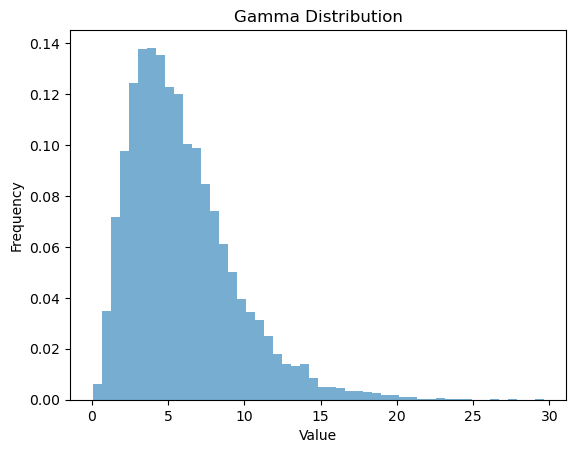

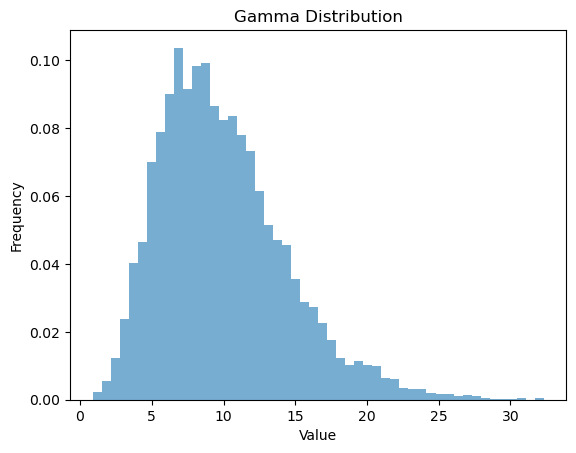

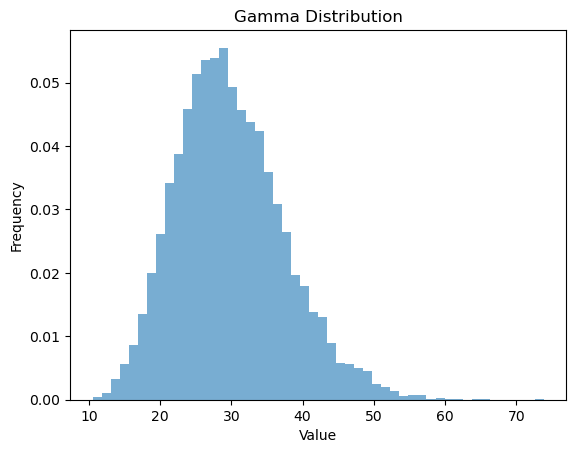

In [254]:
num_samples = 10000  # Number of samples to generate
bins = 50  # Number of bins for the histogram
samples_5d = generate_gamma_samples(3, num_samples)
plot_histogram(samples_5d, bins)

# Generate samples for 5 dimensions
samples_5d = generate_gamma_samples(5, num_samples)
plot_histogram(samples_5d, bins)

# Generate samples for 10 dimensions
samples_10d = generate_gamma_samples(15, num_samples)
plot_histogram(samples_10d, bins)

In [389]:
def calculate_hypersphere_volume(radius, dimensions):
    numerator = math.pi**(dimensions/2) * radius**dimensions
    denominator = math.gamma(dimensions/2 + 1)
    volume = numerator / denominator
    return volume

def generate_example_data(dimensions = 20):
    data = { 'dimensions': [], 'volume': [] }
    for i in range(1, dimensions):
        volume = calculate_hypersphere_volume(1, i)
        data['dimensions'].append(i)
        data['volume'].append(volume)
    return pd.DataFrame(data)

In [390]:
df = generate_example_data()
df.head()

,dimensions,volume
0,1,2.000000
1,2,3.141593
2,3,4.188790
3,4,4.934802
4,5,5.263789


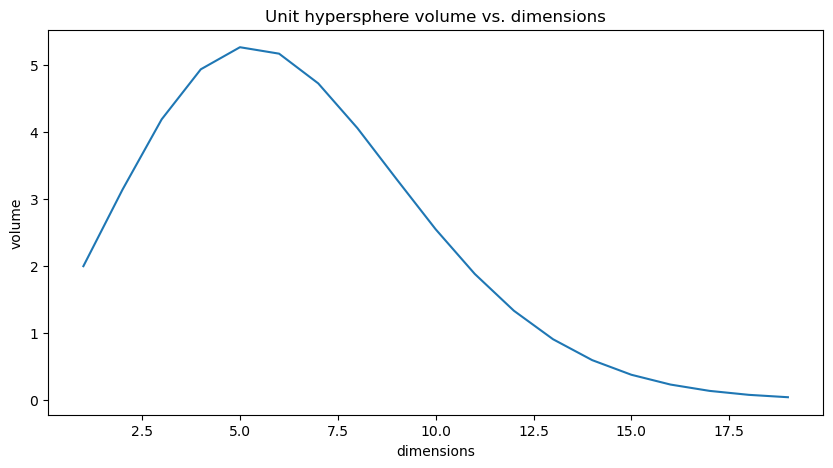

In [397]:
import seaborn as sns
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='dimensions', y='volume', data=df, ax=fig.gca())
fig.gca().set_title('Unit hypersphere volume vs. dimensions')
plt.show()
